# Exploratory Data Analysis

### Description

* Arabizi is a combination of english and arabic languages making arabic "izi" for communicatiopn over internet.

In [1]:
import sys 
sys.path.append('../scripts')

In [2]:
import os
import pandas as pd
import numpy as np
from collections import Counter

from config import Config
from tqdm.auto import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
from utils import remove_repetitions, replace_accents, delete_outliers, show_lengths_distribution

### Some statistics

In [3]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'Train.csv'))
test_df = pd.read_csv(os.path.join(Config.data_dir, 'Test.csv'))

In [4]:
total_samples = len(train_df) + len(test_df)
total_samples

100000

In [5]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,70000.0,0.127771,0.973889,-1.0,-1.0,1.0,1.0,1.0


In [6]:
train_df.isna().sum()

ID       0
text     0
label    0
dtype: int64

In [7]:
test_df.isna().sum()

ID      0
text    0
dtype: int64

In [8]:
train_df.text.duplicated().sum()

0

In [9]:
test_df.text.duplicated().sum()

0

In [10]:
train_df.tail()

,ID,text,label
69995,ZRSR7TZ,pff bayna beli kbira f wejhakk yakhiii rouhi r...,-1
69996,QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1
69997,LJ2K9MD,winha nakhtabha hhhhh,-1
69998,5RZ1T7I,fachel enta w houwa,-1
69999,WZCF7CL,nchla lyouma nesm3ou a5beer bahiya 3la jem3iya,1


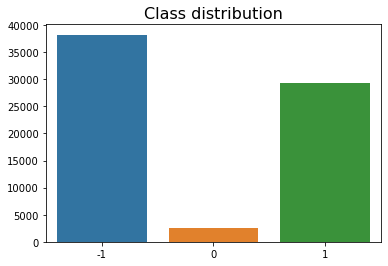

In [11]:
sb.barplot(x=train_df.label.unique(), y=train_df.label.value_counts().tolist(), data=train_df)
plt.title('Class distribution', size=16)
plt.show()

In [20]:
train_df[train_df['label'] == 0].shape

(2466, 3)

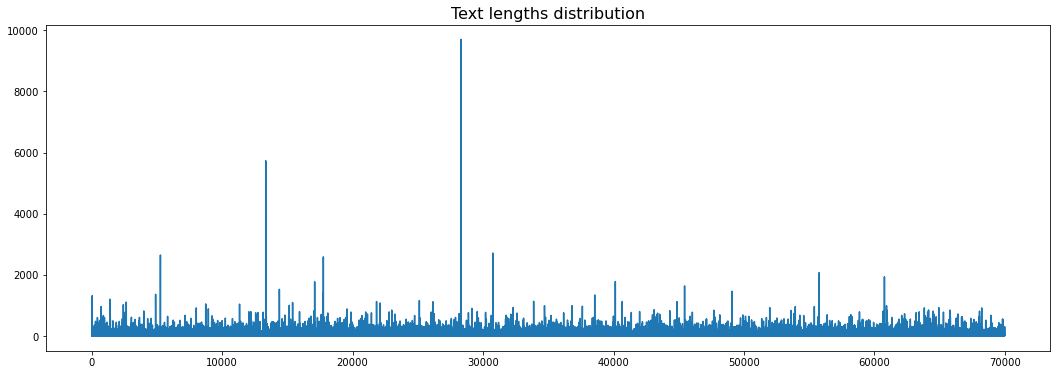

In [12]:
show_lengths_distribution(data = train_df)

# Data Preprocessing

The given dataset has :
* many texts with letters that are repeted exaggeratedly. --> limit these repetitions
* many french words that are known to have accented letters --> replace these letters

### Data cleaning

In [13]:
# example of repeated letters removal
print(train_df.iloc[0].text + " 100000 pfffff aaaaaahhh")
print(remove_repetitions(sequence=train_df.iloc[0].text + " 100000 pfffff aaaaaahhh", n_repetitions=2))

3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi ou 3sbaaaaaaaaaaaaaaaaaaaaaaaaaaa le ca 100000 pfffff aaaaaahhh
3sbaa lek ou le seim riahi ou 3sbaa le ca 100000 pff aahh


In [14]:
%%time
train_df['text'] = train_df['text'].apply(lambda text: replace_accents(remove_repetitions(sequence=text, n_repetitions=2)))
train_df.head()

CPU times: user 902 ms, sys: 4 ms, total: 906 ms
Wall time: 907 ms


,ID,text,label
0,13P0QT0,3sbaa lek ou le seim riahi ou 3sbaa le ca,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [15]:
print(train_df.iloc[0].text)

3sbaa lek ou le seim riahi ou 3sbaa le ca


In [16]:
# SAVE CLEANED_DATA
train_df.to_csv(
    os.path.join(Config.data_dir, 'cleaned_train.csv'), 
    index=False
)